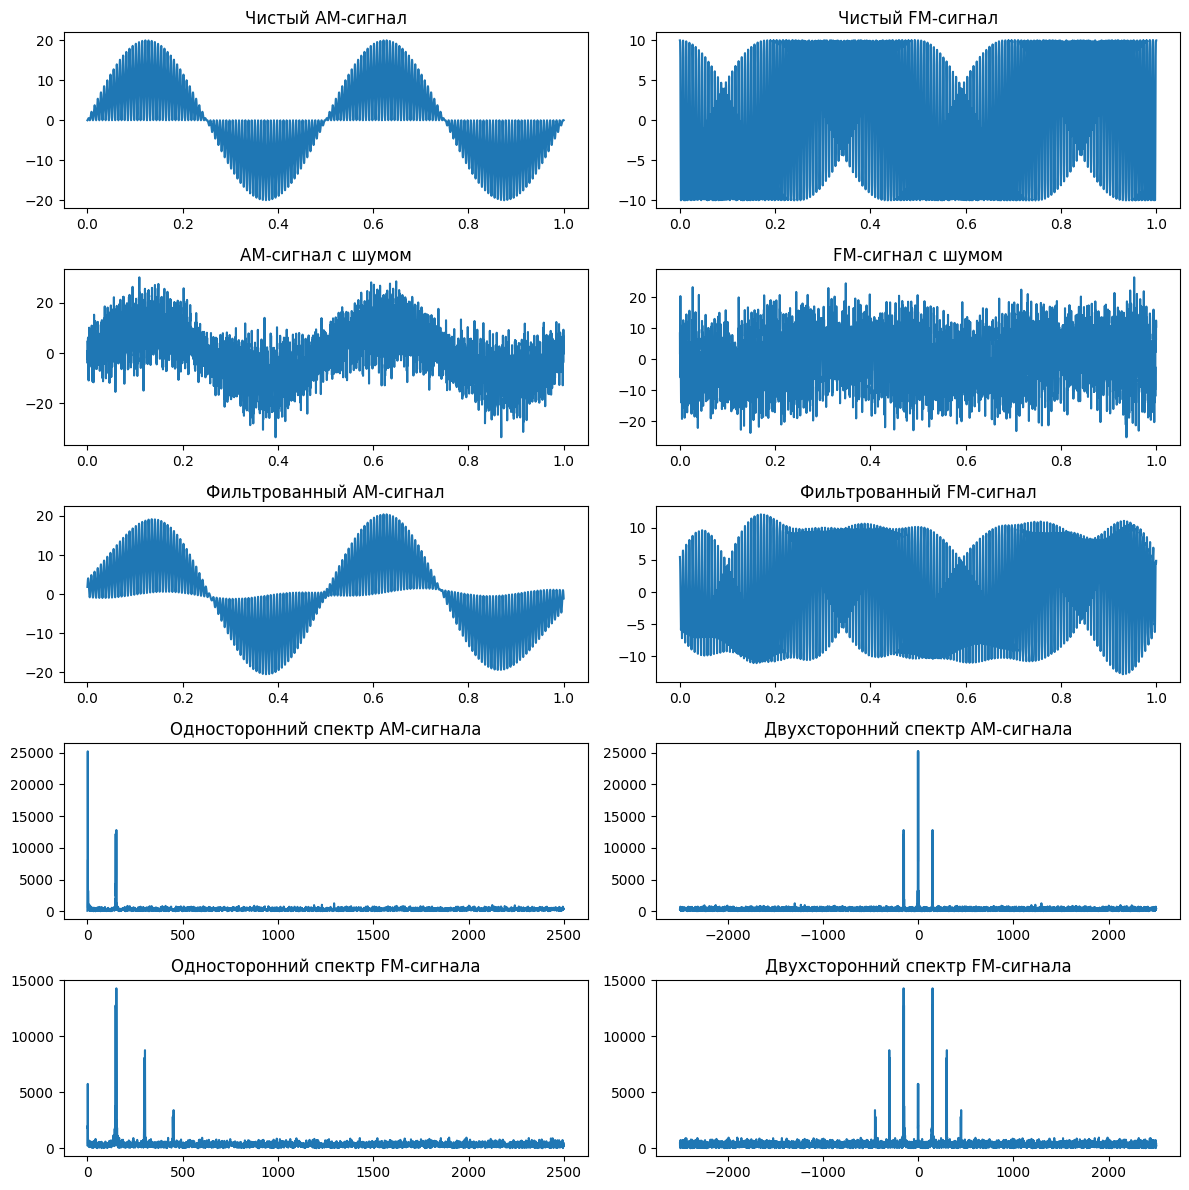

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Параметры
N = 1  # Номер варианта
Fs = 5000  # Частота дискретизации
T = 1  # Длительность сигнала

t = np.linspace(0, T, Fs * T)

# Определение параметров
if N % 2 == 0:
    A, B, f1, f2 = 15 * N, N, 3 * N, 100 * N
else:
    A, B, f1, f2 = 10 * N, 2 * N, 2 * N, 150 * N

# Генерация несущего и информационного сигналов
carrier = A * np.sin(2 * np.pi * f1 * t)
info = B * np.sin(2 * np.pi * f2 * t)

# АМ-сигнал
am_signal = (1 + info / max(info)) * carrier

# FM-сигнал
kf = 5  # Коэффициент частотной модуляции
fm_signal = A * np.cos(2 * np.pi * f1 * t + 2*np.pi*f2*np.cumsum(info) / Fs)

# Добавление шума
noise_am = am_signal + np.random.normal(0, A / 2, len(t))
noise_fm = fm_signal + np.random.normal(0, A / 2, len(t))

# Функция дополнения до ближайшей степени двойки
def next_power_of_2(n):
    return 1 << (n - 1).bit_length()

# Дополнение сигналов
N_fft = next_power_of_2(len(noise_am))
noise_am_padded = np.pad(noise_am, (0, N_fft - len(noise_am)), mode='constant')
noise_fm_padded = np.pad(noise_fm, (0, N_fft - len(noise_fm)), mode='constant')

# Быстрое преобразование Фурье (FFT) вручную
def fft(signal):
    N = len(signal)
    if N <= 1:
        return signal
    even = fft(signal[0::2])
    odd = fft(signal[1::2])
    terms = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [even[k] + terms[k] for k in range(N // 2)] + [even[k] - terms[k] for k in range(N // 2)]

# Обратное преобразование Фурье (IFFT) вручную
def ifft(spectrum):
    N = len(spectrum)
    spectrum_conj = [np.conj(x) for x in spectrum]
    time_domain = fft(spectrum_conj)
    return [np.conj(x) / N for x in time_domain]

# Спектры
am_spectrum = np.abs(fft(noise_am_padded))
fm_spectrum = np.abs(fft(noise_fm_padded))
frequencies = np.fft.fftfreq(N_fft, d=1/Fs)

# Фильтрация (порог на значения спектра)
def filter_signal(signal, threshold=0.1):
    spectrum = fft(signal)
    spectrum = np.array(spectrum)
    spectrum[np.abs(spectrum) < threshold * max(np.abs(spectrum))] = 0
    return np.real(ifft(spectrum))

filtered_am = filter_signal(noise_am_padded)
filtered_fm = filter_signal(noise_fm_padded)

# Графики
plt.figure(figsize=(12, 12))

plt.subplot(5, 2, 1)
plt.plot(t, am_signal[:len(t)])
plt.title("Чистый AM-сигнал")

plt.subplot(5, 2, 2)
plt.plot(t, fm_signal[:len(t)])
plt.title("Чистый FM-сигнал")

plt.subplot(5, 2, 3)
plt.plot(t, noise_am[:len(t)])
plt.title("AM-сигнал с шумом")

plt.subplot(5, 2, 4)
plt.plot(t, noise_fm[:len(t)])
plt.title("FM-сигнал с шумом")

plt.subplot(5, 2, 5)
plt.plot(t[:len(filtered_am)], filtered_am[:len(t)])
plt.title("Фильтрованный AM-сигнал")

plt.subplot(5, 2, 6)
plt.plot(t[:len(filtered_fm)], filtered_fm[:len(t)])
plt.title("Фильтрованный FM-сигнал")

plt.subplot(5, 2, 7)
plt.plot(frequencies[:N_fft//2], am_spectrum[:N_fft//2])
plt.title("Односторонний спектр AM-сигнала")

plt.subplot(5, 2, 8)
plt.plot(frequencies, am_spectrum)
plt.title("Двухсторонний спектр AM-сигнала")

plt.subplot(5, 2, 9)
plt.plot(frequencies[:N_fft//2], fm_spectrum[:N_fft//2])
plt.title("Односторонний спектр FM-сигнала")

plt.subplot(5, 2, 10)
plt.plot(frequencies, fm_spectrum)
plt.title("Двухсторонний спектр FM-сигнала")

plt.tight_layout()
plt.show()
